In [57]:
from distribution import Distribution
from solvers import BetaPolicyBanditSolver
import matplotlib.pyplot as plt
import numpy as np
from tueplots import bundles, figsizes

In [58]:
plt.rcParams.update({
    "text.usetex": True,
})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [59]:
#beta means
def u(mu:Distribution,beta:float)->float:
    if beta == 0:
        return mu.mean
    else:
        return np.log(sum([mu_i*np.exp(beta*x_i) for (x_i,mu_i) in mu._values()]))/beta

def r_max(mu:Distribution)->float:
    return max(mu._atoms())

def r_min(mu:Distribution)->float:
    return min(mu._atoms())

def tv_distance(mu1:Distribution,mu2:Distribution)->float:
    return sum([np.abs(mu1_i-mu2_i) for (mu1_i,mu2_i) in zip(mu1._coefficients(),mu2._coefficients())])

def other_interval(mu1:Distribution, mu2: Distribution, beta:float, beta_max:float)->float:
    r_m = max(r_max(mu1),r_max(mu2))
    lip_coeff = tv_distance(mu1,mu2)*np.exp(beta_max*r_m)*r_m
    return beta + (np.abs(u(mu1,beta)-u(mu2,beta))/lip_coeff)

def generating_random_distribution(n_atoms:int, reward_min=0, reward_max=1)->Distribution:
    #from https://cs.stackexchange.com/questions/3227/uniform-sampling-from-a-simplex
    n = n_atoms
    diff_reward = reward_max-reward_min

    numbers = np.random.rand(n-1)
    numbers.sort()
    numbers =  np.array([0]+list(numbers)+[1])
    return Distribution({reward_min + (diff_reward*(i/(n-1))):numbers[i+1]-numbers[i] for i in range(n)})

In [60]:
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(figsizes.icml2022_half())
plt.rcParams.update({"figure.dpi": 150})

# Expé 1 : Évolution du nombre de calcul comparé à grid search naïf

**Objectif** : Observer le gain de performance de l’algorithme par rapport à une grid search naïve.

**Méthode** : Faire varier les paramètres de précision de l’algo et d’interval de résolution, pour chaque paire de paramètre, générer plusieurs problèmes et les résoudre. Comparer le nombre d’intervals calculés par rapport à la méthode naïve.

**Paramètres** :
- grid_search_accuracies : liste de précisions de résolution
  - [1e-1, 1e-3], 10 points, log scale
- intervals : interval de résolution testés
  - ± 0.15, 1, 5, 10
- run_per_pt : nombre d’expérience par paire de paramètre
  - 20
- nb_actions : nombres de distributions 
  - 8
- nb_atoms : atomes par distributions 
  - 20


In [61]:
#parameters

#np random seed
seed = None
#TODO : add the np seed method to control the experiments

###grid search
accuracy_max = 1e-3
accuracy_min = 1e-1
nb_points = 10

###Distributions
nb_actions = 8
nb_atoms = 20
reward_max = 1
reward_min = 0

###Intervales
intervals = [(-0.15, 0.15), (-1,1), (-5,5), (-10,10)]

### Expés param
run_per_pt = 20
#run_per_pt = 1

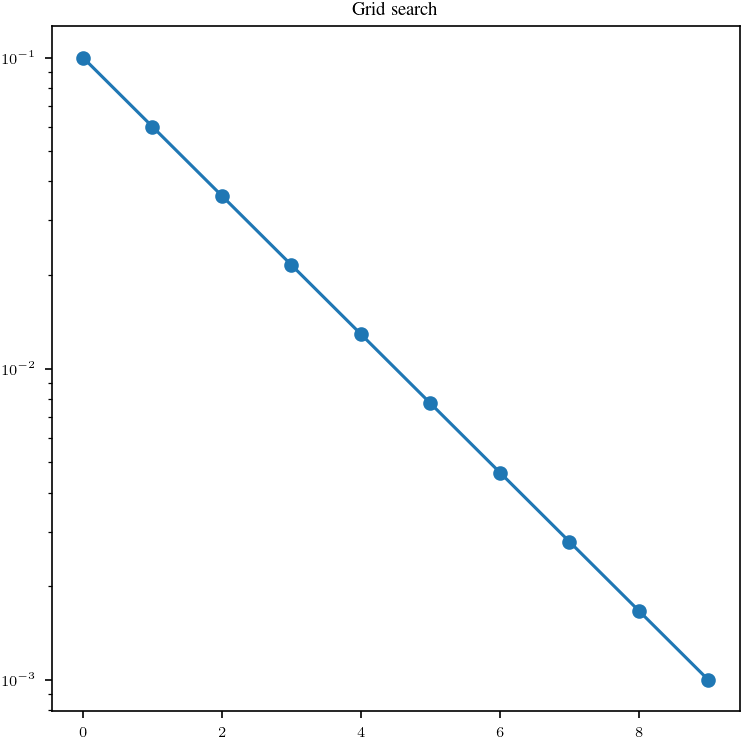

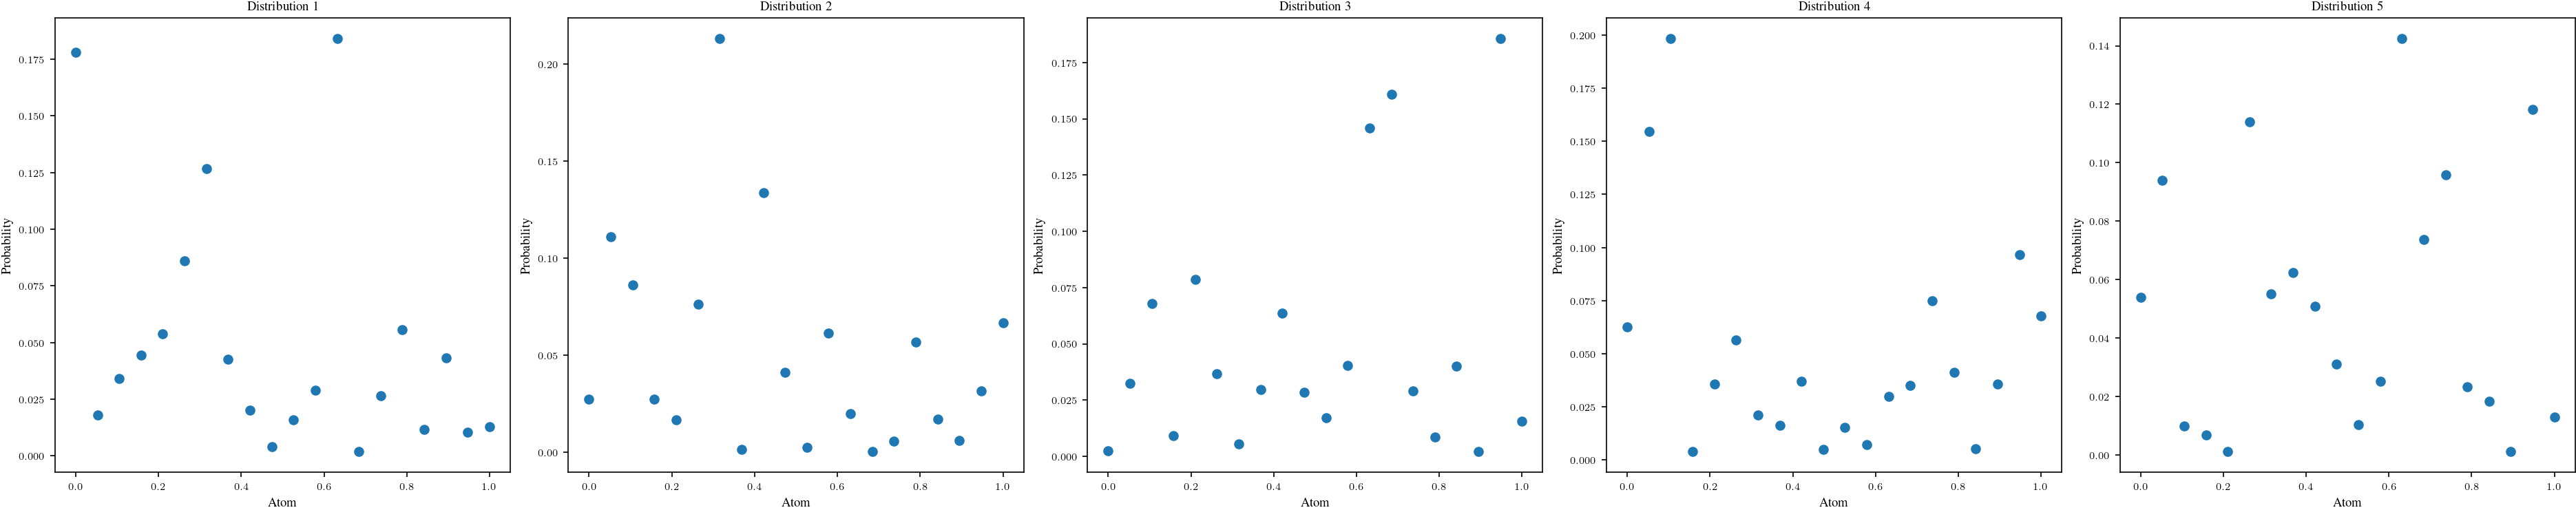

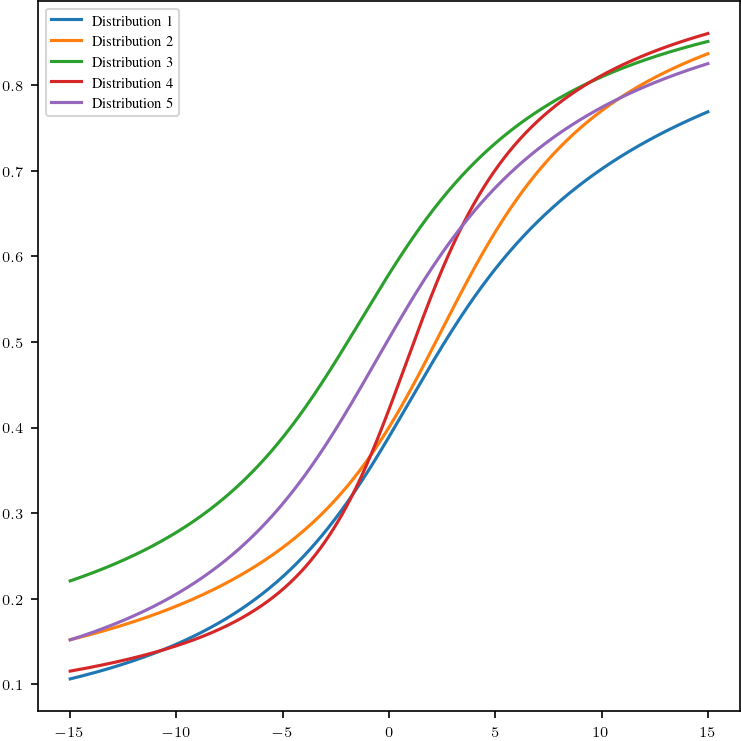

In [62]:
#Initialization
grid_search_accuracies = np.exp(np.linspace(np.log(accuracy_max),np.log(accuracy_min), nb_points))[::-1]
atoms = np.linspace(reward_min, reward_max, nb_atoms)
distributions = [generating_random_distribution(nb_atoms, reward_min, reward_max) for _ in range(nb_actions)]

#plot grid search points
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(grid_search_accuracies, label='Accuracy', marker='o')
ax.set_title('Grid search')
ax.set_yscale('log')

#plot distributions
nb_max_plot = 5
fig, ax = plt.subplots(1, nb_max_plot, figsize=(nb_max_plot*5, 5))
for i in range(nb_max_plot):
    ax[i].scatter(atoms, distributions[i]._coefficients())
    ax[i].set_title('Distribution {}'.format(i+1))
    ax[i].set_xlabel('Atom')
    ax[i].set_ylabel('Probability')

#plot q values
abs = np.linspace(-15,15,1000)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(nb_max_plot):
    u_values = [u(distributions[i], beta) for beta in abs]
    ax.plot(abs, u_values, label=f'Distribution {i+1}')
ax.legend()


In [63]:
#Run experiments
solver = BetaPolicyBanditSolver(distributions, accuracy=accuracy_max)
print(solver.intervals_computed)


#return values
values = np.zeros((nb_points, len(intervals), run_per_pt))


0


In [64]:
for run in range(run_per_pt):
    #all different accuracy and intervals are tested on the same distributions
    distributions = [generating_random_distribution(nb_atoms, reward_min, reward_max) for _ in range(nb_actions)]

    for accuracy_idx in range(len(grid_search_accuracies)):
        accuracy = grid_search_accuracies[accuracy_idx]

        solver = BetaPolicyBanditSolver(distributions, accuracy=accuracy)
        for interval_idx in range(len(intervals)):
            interval = intervals[interval_idx]
            print(f"Run {run}, accuracy {accuracy}, interval {interval}")

            solver._solve_interval(interval[0], interval[1], reset=True)
            print(solver.intervals_computed)
            print(solver.crossings)
            values[accuracy_idx, interval_idx, run] = solver.intervals_computed

Run 0, accuracy 0.10000000000000002, interval (-0.15, 0.15)
2
[]
Run 0, accuracy 0.10000000000000002, interval (-1, 1)
18
[]
Run 0, accuracy 0.10000000000000002, interval (-5, 5)
65
[-1.3000000000000003]
Run 0, accuracy 0.10000000000000002, interval (-10, 10)
91
[-1.3000000000000003]
Run 0, accuracy 0.05994842503189412, interval (-0.15, 0.15)
4
[]
Run 0, accuracy 0.05994842503189412, interval (-1, 1)
32
[]
Run 0, accuracy 0.05994842503189412, interval (-5, 5)
90
[-1.31886535070167]
Run 0, accuracy 0.05994842503189412, interval (-10, 10)
116
[-1.31886535070167]
Run 0, accuracy 0.035938136638046285, interval (-0.15, 0.15)
8
[]
Run 0, accuracy 0.035938136638046285, interval (-1, 1)
51
[]
Run 0, accuracy 0.035938136638046285, interval (-5, 5)
124
[-1.2937729189696652]
Run 0, accuracy 0.035938136638046285, interval (-10, 10)
149
[-1.2937729189696652]
Run 0, accuracy 0.02154434690031885, interval (-0.15, 0.15)
12
[]
Run 0, accuracy 0.02154434690031885, interval (-1, 1)
80
[]
Run 0, accuracy 

[[  2.    17.85  73.5  111.55]
 [  4.    30.4  103.8  149.85]
 [  8.    47.   140.95 193.5 ]
 [ 12.    69.45 187.2  246.  ]
 [ 21.7   98.15 242.   307.2 ]
 [ 35.3  133.85 306.45 378.1 ]
 [ 53.7  178.   383.1  460.9 ]
 [ 77.65 234.95 472.   556.15]
 [107.6  305.2  572.1  662.1 ]
 [146.   382.1  675.2  771.7 ]]


C:\Users\Alex\AppData\Local\Temp\ipykernel_19732\3320386137.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


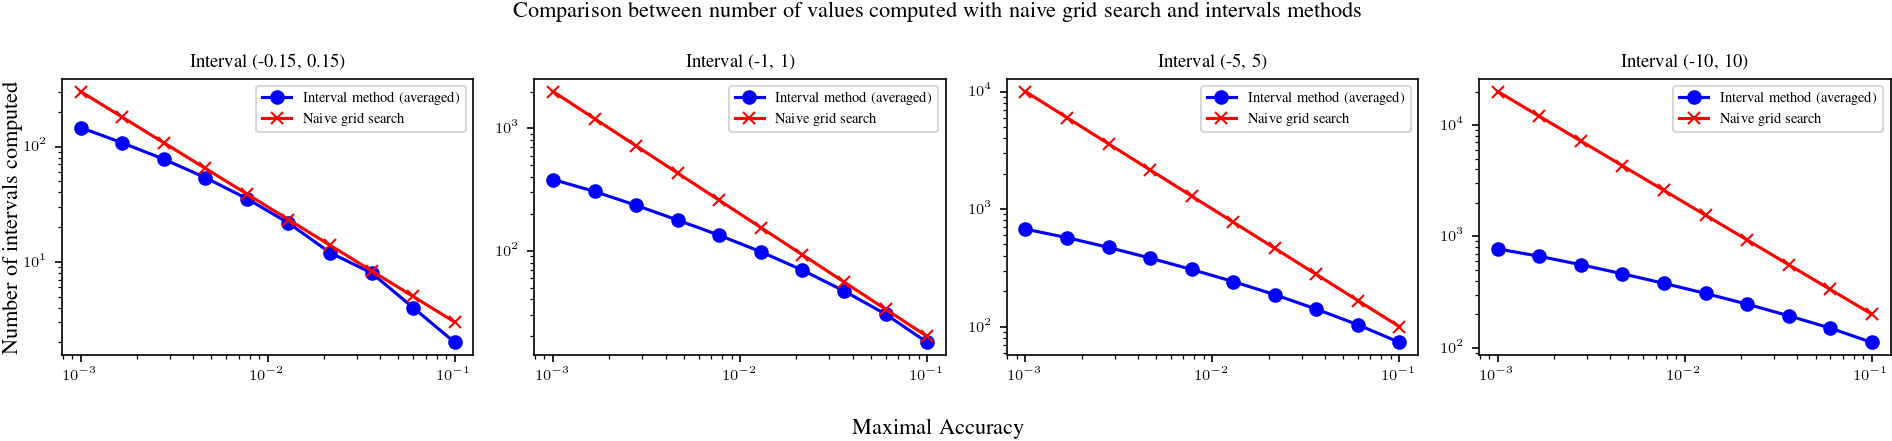

In [65]:
#plot values
values_avg = np.average(values, axis=2)
print(values_avg)
fig, ax = plt.subplots(1, len(intervals), figsize=(3*len(intervals)+1, 3))
for interval_idx in range(len(intervals)):

    #naive_grid_search intervals computed
    interval = intervals[interval_idx]
    interval_span = interval[1] - interval[0]
    naive_grid_search_intervals = [interval_span/accuracy for accuracy in grid_search_accuracies]

    ax[interval_idx].plot(grid_search_accuracies, values_avg[:, interval_idx], label='Interval method (averaged)', color='blue', marker='o')
    ax[interval_idx].plot(grid_search_accuracies, naive_grid_search_intervals, label='Naive grid search', color='red', marker='x')
    ax[interval_idx].set_xscale('log')
    ax[interval_idx].set_yscale('log')
    ax[interval_idx].set_title(f'Interval {intervals[interval_idx]}')
    ax[interval_idx].legend()

fig.supxlabel('Maximal Accuracy')
fig.supylabel('Number of intervals computed')
fig.suptitle('Comparison between number of values computed with naive grid search and intervals methods')
fig.tight_layout()

[[  2.    17.85  73.5  111.55]
 [  4.    30.4  103.8  149.85]
 [  8.    47.   140.95 193.5 ]
 [ 12.    69.45 187.2  246.  ]
 [ 21.7   98.15 242.   307.2 ]
 [ 35.3  133.85 306.45 378.1 ]
 [ 53.7  178.   383.1  460.9 ]
 [ 77.65 234.95 472.   556.15]
 [107.6  305.2  572.1  662.1 ]
 [146.   382.1  675.2  771.7 ]]


Text(0.5, 0.98, 'Ratio between naive grid search and computed intervals')

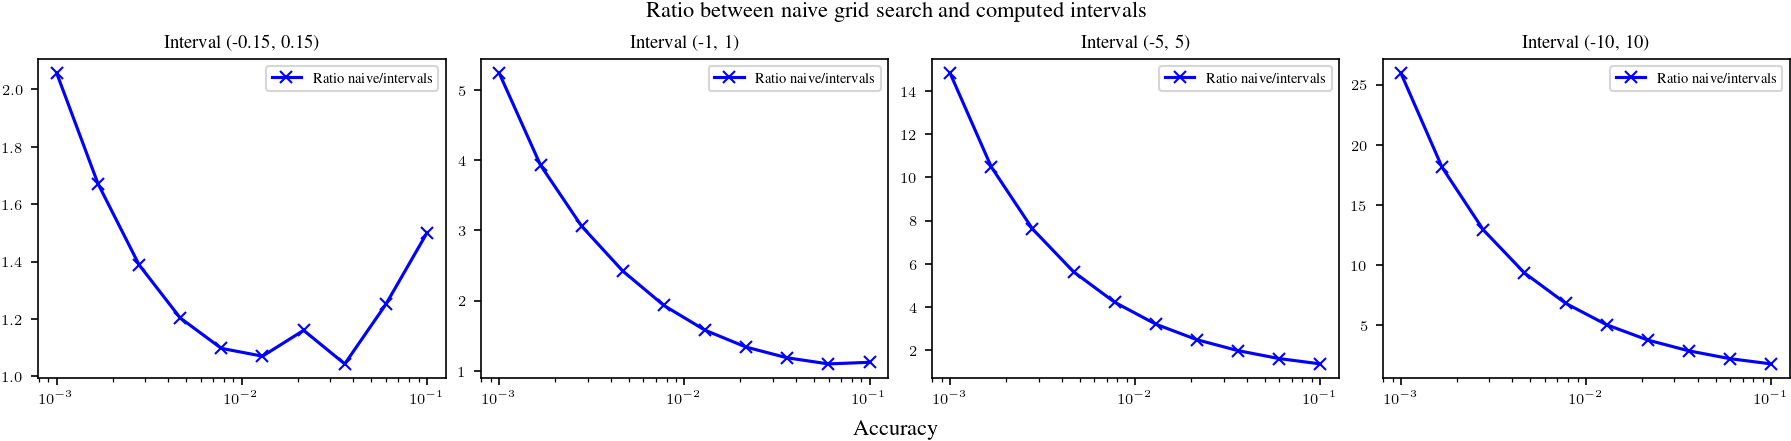

In [66]:
#plot values
values_avg = np.average(values, axis=2)
print(values_avg)
fig, ax = plt.subplots(1, len(intervals), figsize=(3*len(intervals), 3))
for interval_idx in range(len(intervals)):

    #naive_grid_search intervals computed
    interval = intervals[interval_idx]
    interval_span = interval[1] - interval[0]
    naive_grid_search_intervals = [interval_span/accuracy for accuracy in grid_search_accuracies]

    ax[interval_idx].plot(grid_search_accuracies, naive_grid_search_intervals/values_avg[:, interval_idx], label='Ratio naive/intervals', color='blue', marker='x')
    ax[interval_idx].set_xscale('log')
    ax[interval_idx].set_title(f'Interval {intervals[interval_idx]}')
    ax[interval_idx].legend()
    
fig.supxlabel('Accuracy')
fig.suptitle('Ratio between naive grid search and computed intervals')

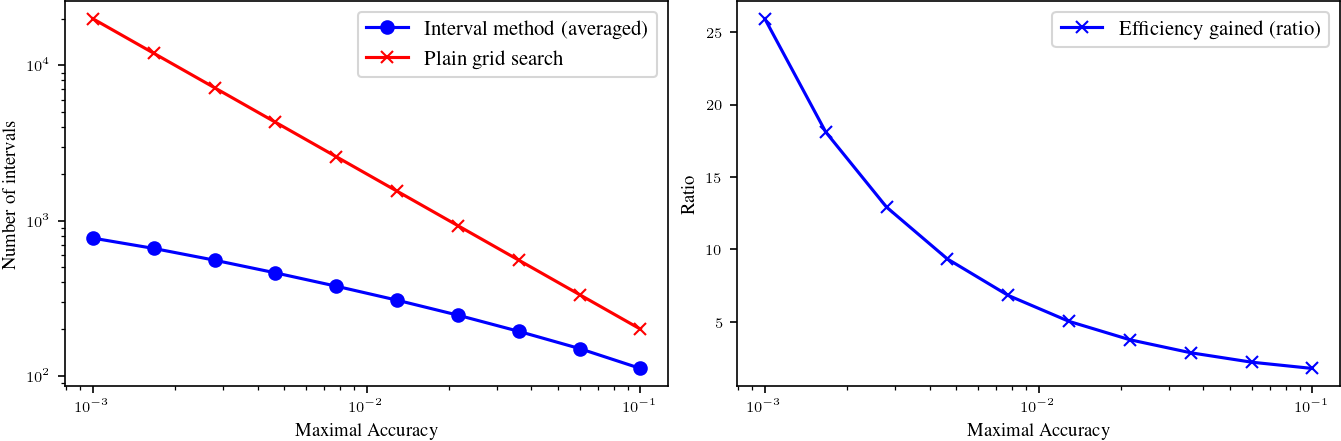

In [67]:
#Print the big intervals
interval_idx = 3

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
interval = intervals[interval_idx]
interval_span = interval[1] - interval[0]
naive_grid_search_intervals = [interval_span/accuracy for accuracy in grid_search_accuracies]

ax[0].plot(grid_search_accuracies, values_avg[:, interval_idx], label='Interval method (averaged)', color='blue', marker='o')
ax[0].plot(grid_search_accuracies, naive_grid_search_intervals, label='Plain grid search', color='red', marker='x')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(prop={'size': 10})

ax[0].set_xlabel('Maximal Accuracy')
ax[0].set_ylabel('Number of intervals')


ax[1].plot(grid_search_accuracies, naive_grid_search_intervals/values_avg[:, interval_idx], label='Efficiency gained (ratio)', color='blue', marker='x')
ax[1].set_xscale('log')
ax[1].legend(prop={'size': 10})

ax[1].set_xlabel('Maximal Accuracy')
ax[1].set_ylabel('Ratio')

#fig.suptitle('Comparison between number of values computed with naive grid search and intervals methods')
fig.savefig('intervals_vs_naive.pdf')

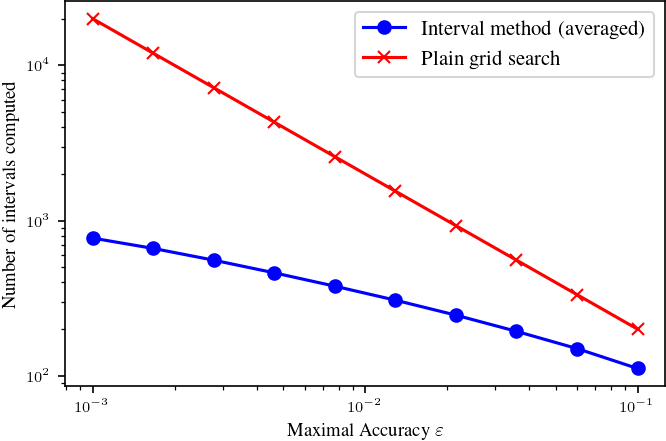

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
interval = intervals[interval_idx]
interval_span = interval[1] - interval[0]
naive_grid_search_intervals = [interval_span/accuracy for accuracy in grid_search_accuracies]

ax.plot(grid_search_accuracies, values_avg[:, interval_idx], label='Interval method (averaged)', color='blue', marker='o')
ax.plot(grid_search_accuracies, naive_grid_search_intervals, label='Plain grid search', color='red', marker='x')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(prop={'size': 10})

ax.set_xlabel(r'Maximal Accuracy $\varepsilon$')
ax.set_ylabel('Number of intervals computed')

fig.savefig('intervals_vs_naive_comp.pdf')

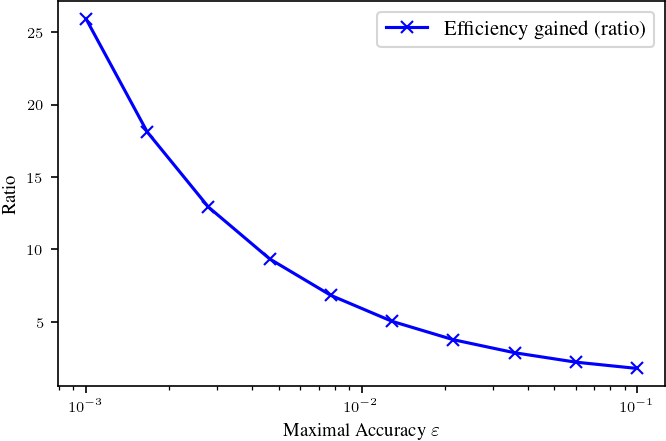

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))

ax.plot(grid_search_accuracies, naive_grid_search_intervals/values_avg[:, interval_idx], label='Efficiency gained (ratio)', color='blue', marker='x')
ax.set_xscale('log')
ax.legend(prop={'size': 10})

ax.set_xlabel(r'Maximal Accuracy $\varepsilon$')
ax.set_ylabel('Ratio')

fig.savefig('intervals_vs_naive_ratio.pdf')

In [70]:
print("Done")

Done


# Expé 2 : Histogramme du nombre de changements

**Objectif** : Observer comment se distribue le nombre de breakpoints, pour differents paramètres.

**Méthode** : Pour un certains nombres d’atoms de distributions et d’action, et un certain intervalle, générer de nombreuses distributions, résoudre, observer la répartition du nombre de breakpoints. Faire varier selon le nombre d’atomes ou d’actions

**Paramètres** :
 - nb_atoms_list : nombres d’atomes
   - 5, **10**, 20, 50
 - nb_actions_list : nombres d’actions
   - 5, **10**, 20, 50
 - interval : interval de résolution utilisé
   - -15, 15
 - accuracy : accuracy utilisée dans le solver
   - 1e-2
 - nb_run : nombre de résolution calculé pour obtenir la répartition
   - 100

The bold parameter is the one fixed when the other are changing

### En fonction du nombre d’atomes

In [71]:
#Parameters

#rng
seed = None
#TODO : add the np seed method to control the experiments

#distributions
nb_atoms_list = [5,10,20,50]
nb_actions = 10
reward_min = 0
reward_max = 1

#solver
interval = (-15,15)
accuracy = 1e-2

#Runs
nb_run = 100

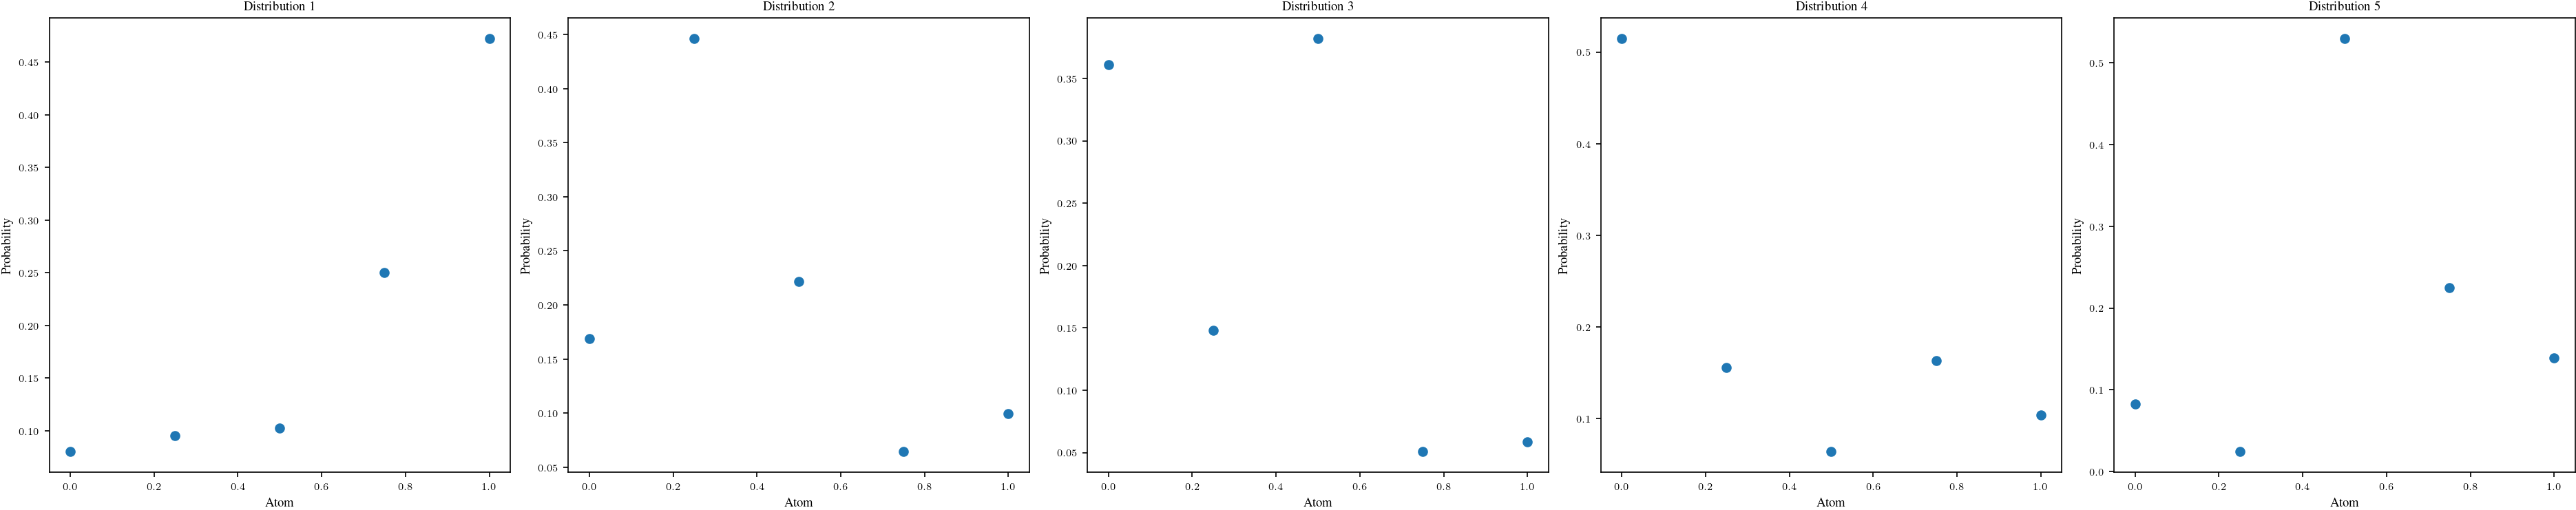

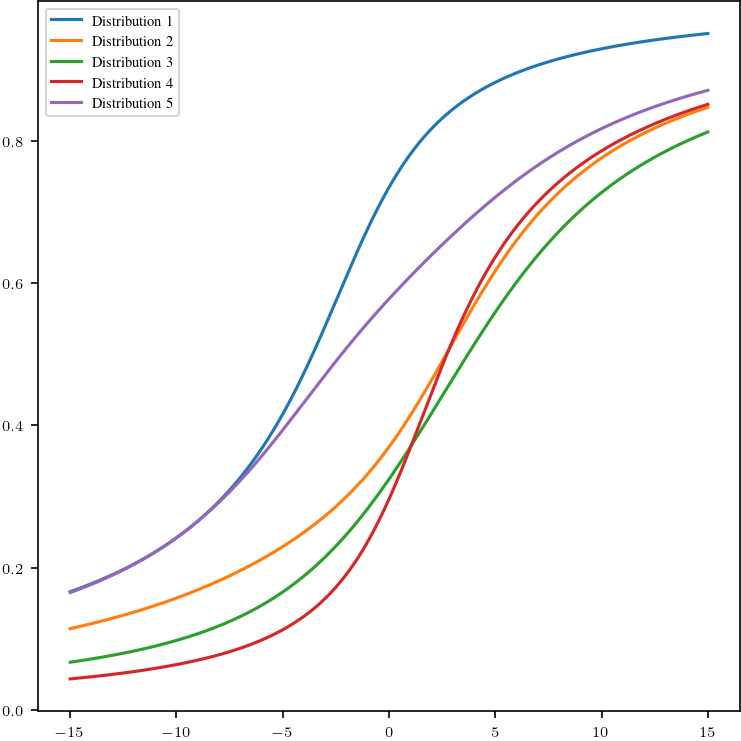

In [72]:
#Initialization
atoms = np.linspace(reward_min, reward_max, nb_atoms_list[0])
distributions = [generating_random_distribution(nb_atoms_list[0], reward_min, reward_max) for _ in range(nb_actions)]

#plot distributions
nb_max_plot = 5
fig, ax = plt.subplots(1, nb_max_plot, figsize=(nb_max_plot*5, 5))
for i in range(nb_max_plot):
    ax[i].scatter(atoms, distributions[i]._coefficients())
    ax[i].set_title('Distribution {}'.format(i+1))
    ax[i].set_xlabel('Atom')
    ax[i].set_ylabel('Probability')

#plot q values
abs = np.linspace(-15,15,1000)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(nb_max_plot):
    u_values = [u(distributions[i], beta) for beta in abs]
    ax.plot(abs, u_values, label=f'Distribution {i+1}')
ax.legend()

In [73]:
nb_crossings = []

for nb_atoms in nb_atoms_list:
    nb_crossings_run = []
    for run in range(nb_run):
        #all different accuracy and intervals are tested on the same distributions
        distributions = [generating_random_distribution(nb_atoms, reward_min, reward_max) for _ in range(nb_actions)]

        solver = BetaPolicyBanditSolver(distributions, accuracy=accuracy_max)
        solver._solve_interval(interval[0], interval[1], reset=True)
        #print(solver.crossings)
        nb_crossings_run.append(len(solver.crossings))
    
    nb_crossings.append(nb_crossings_run)
    print(f"{nb_atoms} atoms : {sum(nb_crossings_run)/nb_run} crossings in average")

5 atoms : 1.43 crossings in average
10 atoms : 1.63 crossings in average
20 atoms : 1.81 crossings in average
50 atoms : 1.8 crossings in average


Text(0.5, 0.98, "Nombre de croisements pour 10 actions et différents nombres d'atomes")

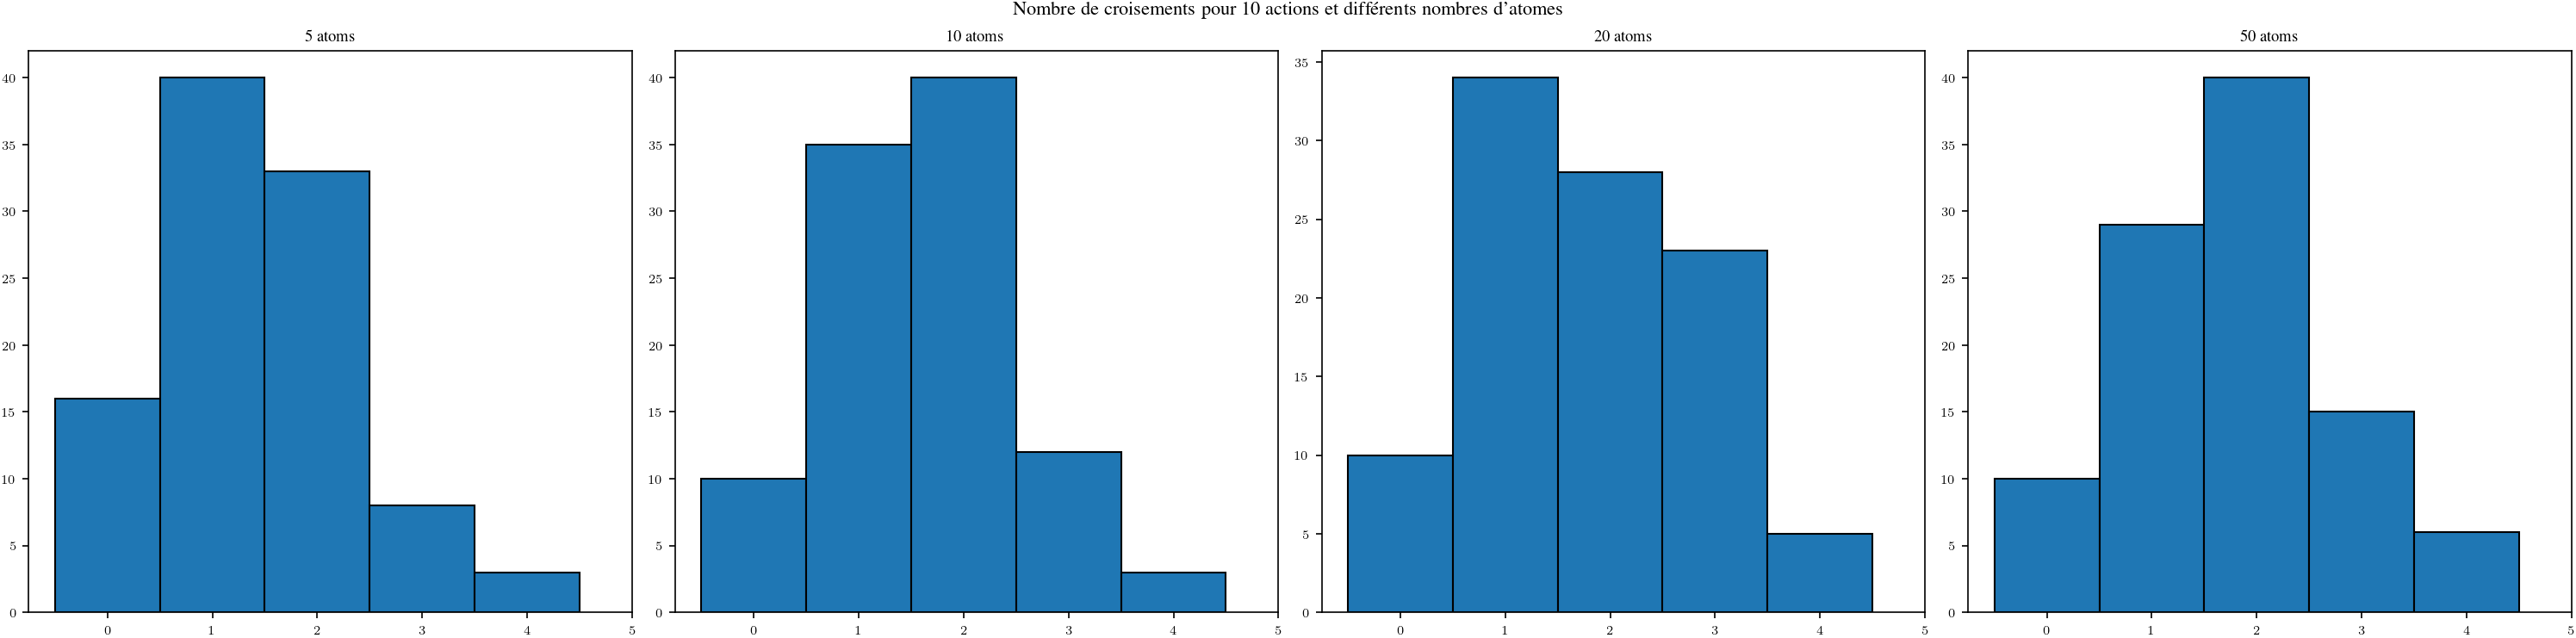

In [74]:
fig, ax = plt.subplots(1, len(nb_atoms_list), figsize=(5*len(nb_atoms_list), 5))
bins = list(range(0, np.max(np.array(nb_crossings))+1))
for i in range(len(nb_atoms_list)):
    ax[i].hist(nb_crossings[i], bins=bins, edgecolor='black', align='left')
    ax[i].set_title(f'{nb_atoms_list[i]} atoms')
    ax[i].set_xticks(bins)
fig.suptitle('Nombre de croisements pour 10 actions et différents nombres d\'atomes')

### En fonction du nombre d’actions

In [75]:
#Parameters

#rng
seed = None
#TODO : add the np seed method to control the experiments

#distributions
nb_atoms = 10
nb_actions_list = [5,10,20,50]
reward_min = 0
reward_max = 1

#solver
interval = (-15,15)
accuracy = 1e-2

#Runs
nb_run = 100

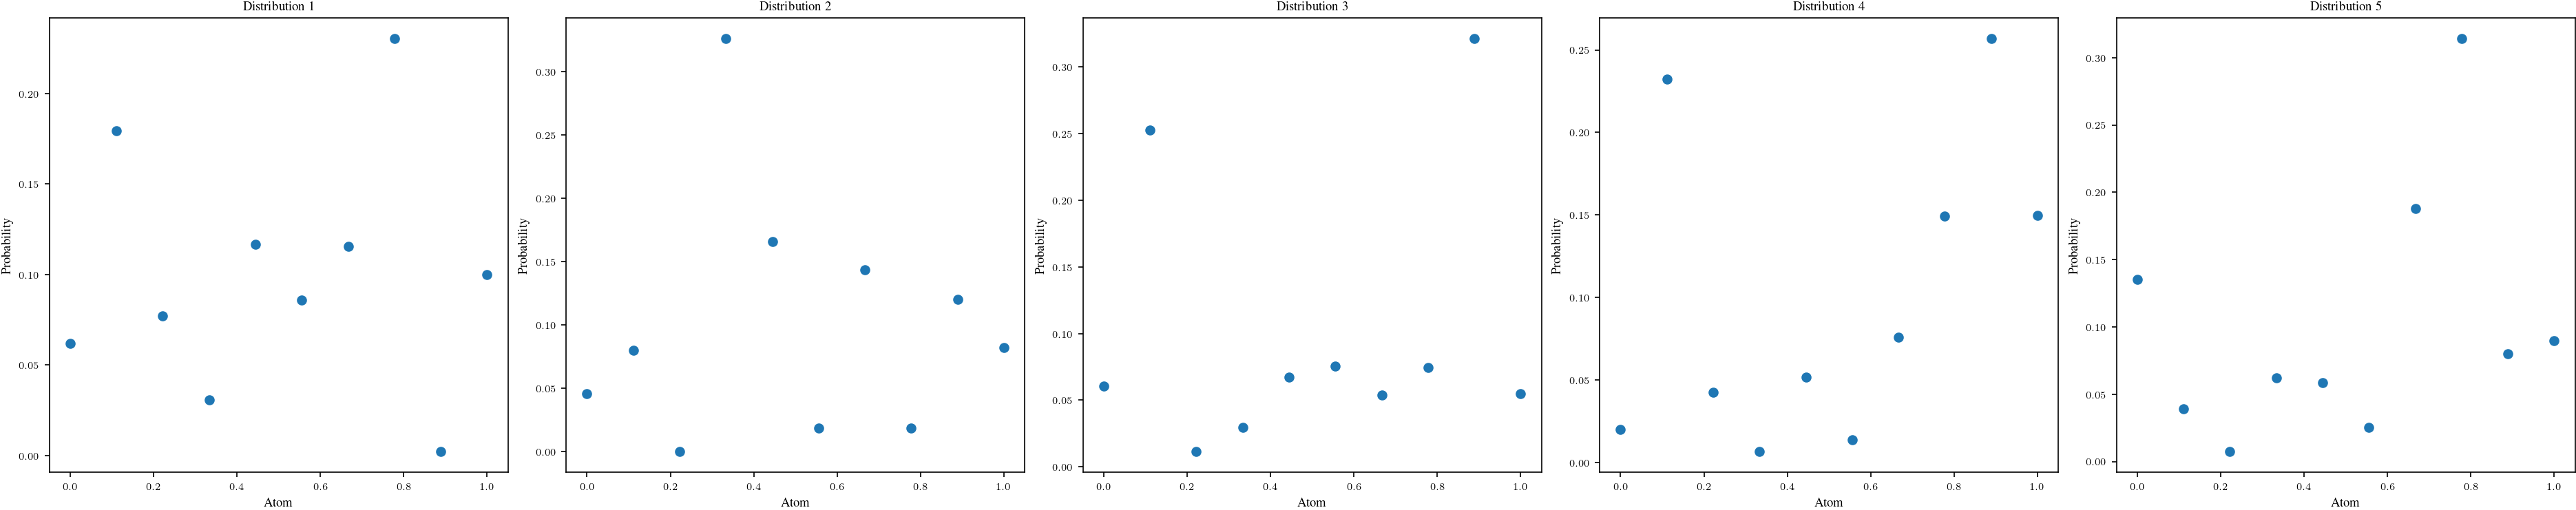

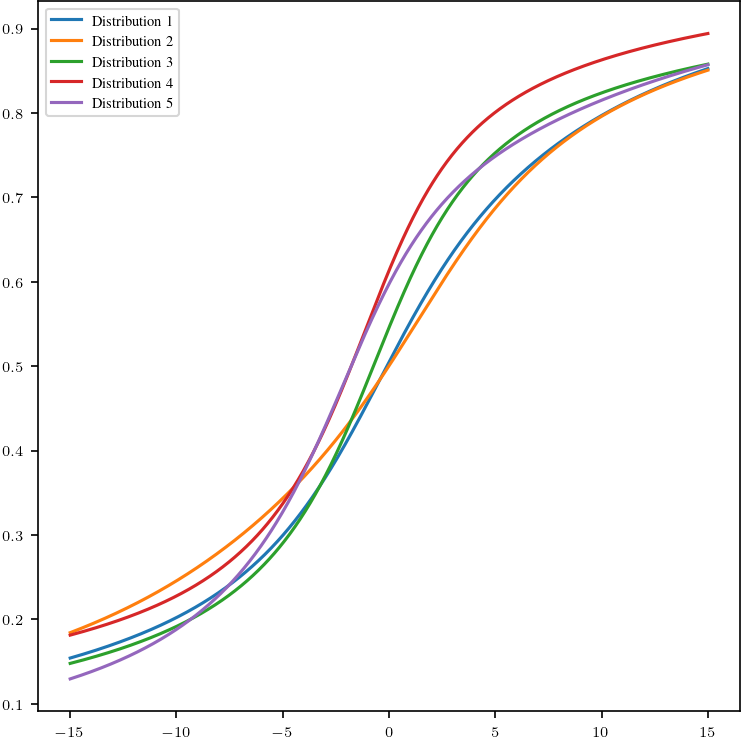

In [76]:
#Initialization
atoms = np.linspace(reward_min, reward_max, nb_atoms)
distributions = [generating_random_distribution(nb_atoms, reward_min, reward_max) for _ in range(nb_actions_list[0])]

#plot distributions
nb_max_plot = 5
fig, ax = plt.subplots(1, nb_max_plot, figsize=(nb_max_plot*5, 5))
for i in range(nb_max_plot):
    ax[i].scatter(atoms, distributions[i]._coefficients())
    ax[i].set_title('Distribution {}'.format(i+1))
    ax[i].set_xlabel('Atom')
    ax[i].set_ylabel('Probability')

#plot q values
abs = np.linspace(-15,15,1000)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(nb_max_plot):
    u_values = [u(distributions[i], beta) for beta in abs]
    ax.plot(abs, u_values, label=f'Distribution {i+1}')
ax.legend()

In [77]:
nb_crossings = []

for nb_actions in nb_actions_list:
    nb_crossings_run = []
    for run in range(nb_run):
        #all different accuracy and intervals are tested on the same distributions
        distributions = [generating_random_distribution(nb_atoms, reward_min, reward_max) for _ in range(nb_actions)]

        solver = BetaPolicyBanditSolver(distributions, accuracy=accuracy_max)
        solver._solve_interval(interval[0], interval[1], reset=True)
        #print(solver.crossings)
        nb_crossings_run.append(len(solver.crossings))
    
    nb_crossings.append(nb_crossings_run)
    print(f"{nb_actions} actions : {sum(nb_crossings_run)/nb_run} crossings in average")

5 actions : 1.38 crossings in average
10 actions : 1.69 crossings in average
20 actions : 2.15 crossings in average
50 actions : 2.39 crossings in average


Text(0.5, 0.98, "Nombre de croisements pour 10 atomes et différents nombres d'actions")

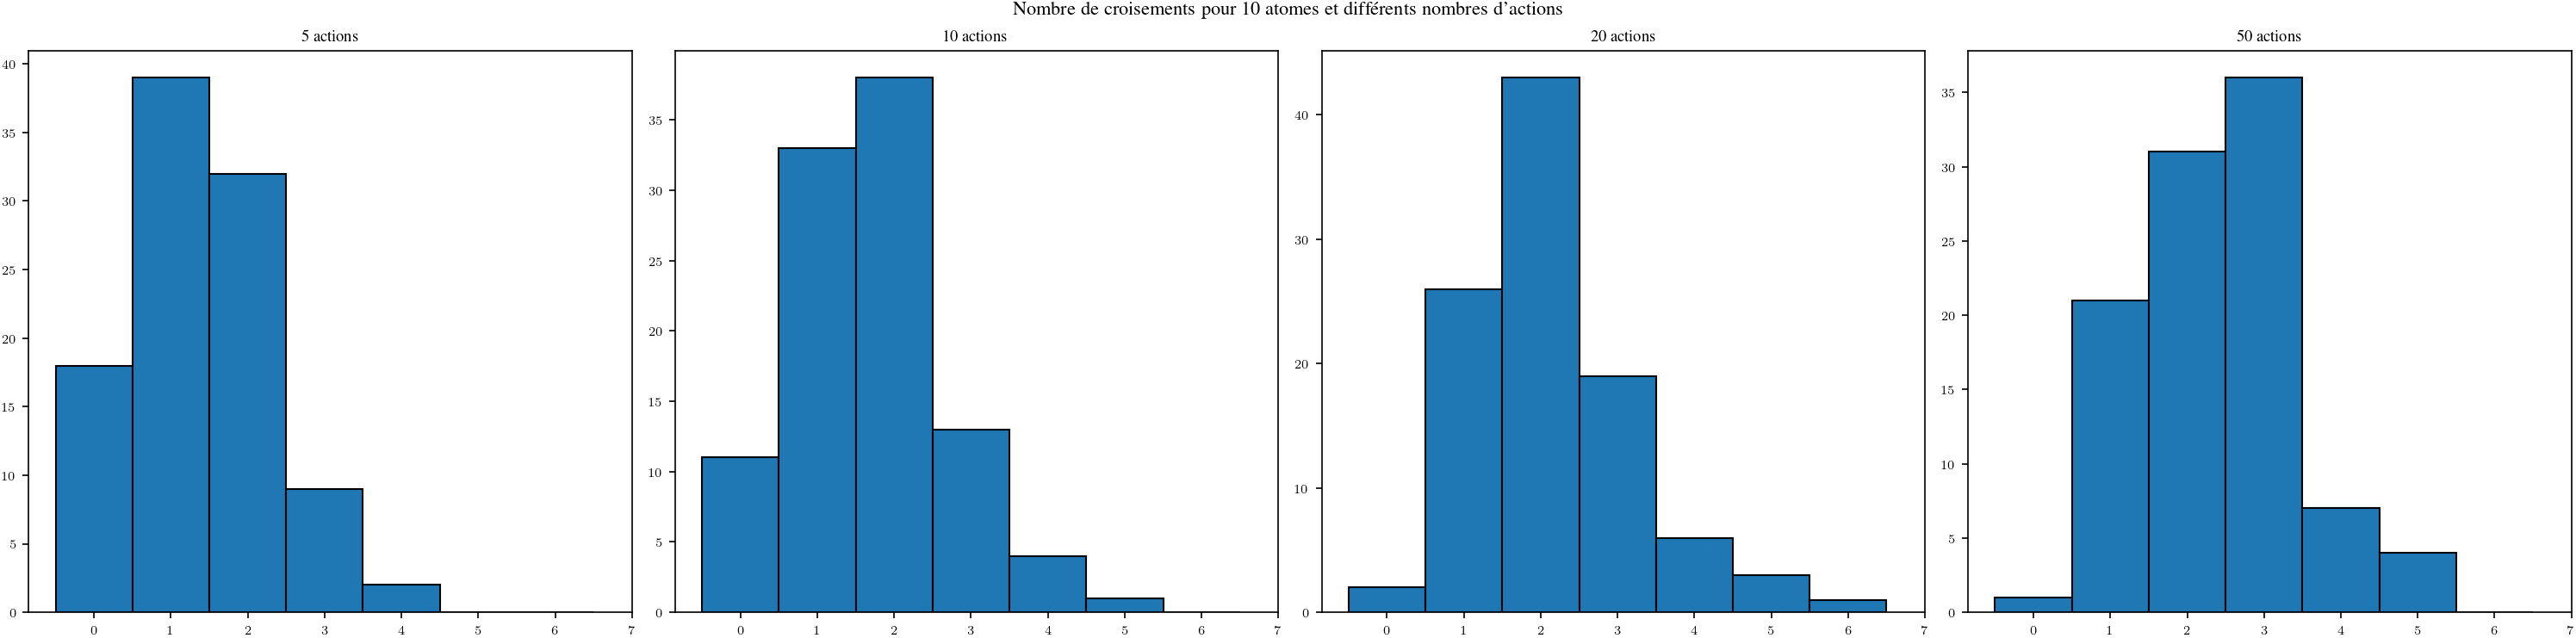

In [78]:
fig, ax = plt.subplots(1, len(nb_actions_list), figsize=(5*len(nb_actions_list), 5))
bins = list(range(0, np.max(np.array(nb_crossings))+1))
for i in range(len(nb_actions_list)):
    ax[i].hist(nb_crossings[i], bins=bins, edgecolor='black', align='left')
    ax[i].set_title(f'{nb_actions_list[i]} actions')
    ax[i].set_xticks(bins)
fig.suptitle('Nombre de croisements pour 10 atomes et différents nombres d\'actions')

# Ilustration Interval

In [79]:
#Parameters
accuracy = 1e-2
beta_max = 8

###distribution
d1 = Distribution({0:0.5, 1:0.5})
d2 = Distribution({0:0.99, 2:0.01})

###Intervales
intervals = []


Text(0, 0.5, 'EntRM')

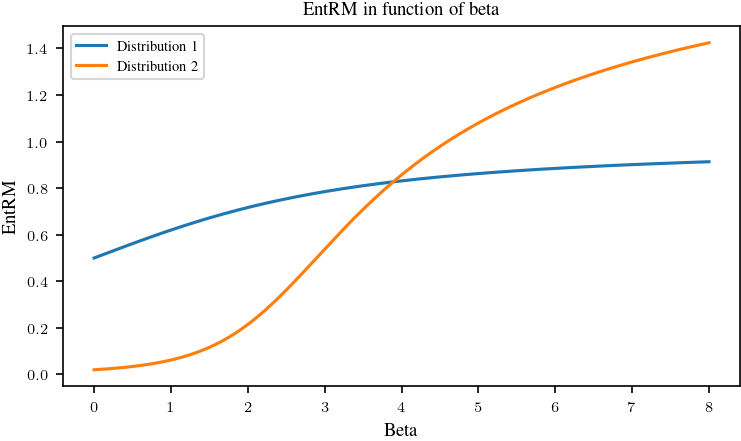

In [80]:
#Print distributions
distributions = [d1, d2]
abs = np.linspace(0,beta_max,1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs]
    ax.plot(abs, u_values, label=f'Distribution {i+1}')
ax.legend()
ax.set_title('EntRM in function of beta')
ax.set_xlabel('Beta')
ax.set_ylabel('EntRM')
#TODO : écrire les distributions dans le label pour meilleure lisibilité


In [92]:
#intervals
solver = BetaPolicyBanditSolver(distributions, accuracy=accuracy)
beta = 8*(d1.mean - d2.mean)/4
intervals = []
intervals.append(beta)
while beta < beta_max:
    print(f"beta : {beta}\r", end='')
    _ , up_bound = solver.compute_safe_interval(beta, d1, d2)
    beta = max(up_bound, beta + accuracy)
    intervals.append(beta)
print("")
print(f"Nombre d’interval : {len(intervals)}")
intervals = intervals[:-1]

beta : 7.8328557638451976
Nombre d’interval : 22


In [93]:
#upper bounds
#intervals
beta =  8*(d1.mean - d2.mean)/4
upper_bounds = []
upper_bounds.append(beta)
while beta < beta_max:
    print(f"beta : {beta}\r", end='')
    _ , up_bound = solver.compute_safe_interval(beta, d1, d2)
    beta = up_bound
    upper_bounds.append(beta)
print("")
print(f"Nombre de bounds : {len(upper_bounds)}")
upper_bounds = upper_bounds[:-1]

beta : 7.1275754890202455
Nombre de bounds : 92


Text(0, 0.5, 'EntRM')

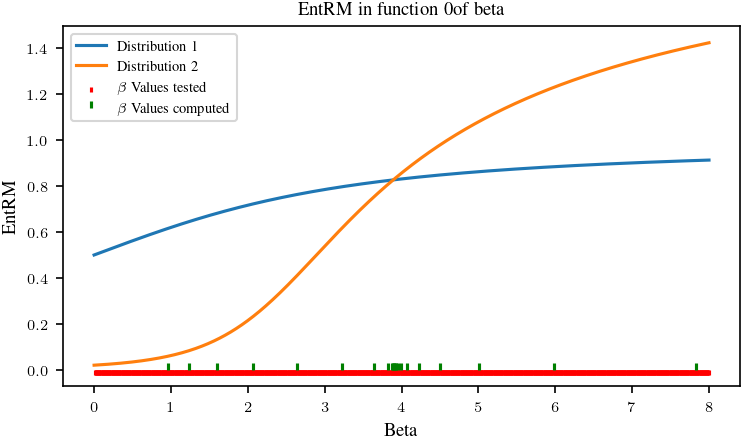

In [94]:
#Afficher la droite.
distributions = [d1, d2]
abs = np.linspace(0,beta_max,1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs]
    ax.plot(abs, u_values, label=f'Distribution {i+1}')
min_accuracy = [accuracy + i*accuracy for i in range(int((beta_max)/accuracy))]
ax.scatter(min_accuracy, [0]*len(min_accuracy), marker=3, color='r', label=r'$\beta$ Values tested', s=5)
ax.scatter(intervals, [0]*len(intervals), marker=2, color='g', label=r'$\beta$ Values computed', s=10)
ax.legend(loc='upper left')
ax.set_title('EntRM in function 0of beta')
ax.set_xlabel('Beta')
ax.set_ylabel('EntRM')


Text(0, 0.5, 'EntRM')

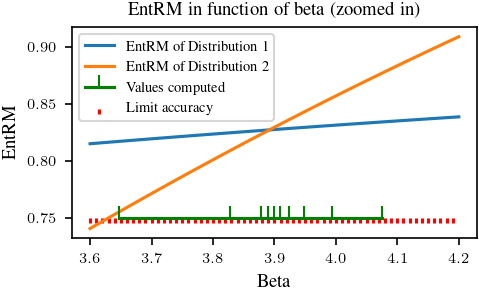

In [95]:
#zoomed in
#Afficher la droite.
b_min, b_max = 3.6, 4.2
z_intervals = [x for x in intervals if x >= b_min and x <= b_max]
abs = np.linspace(b_min,b_max,100)
min_accuracy = [b_min + i*accuracy for i in range(int((b_max - b_min)/accuracy))]
fig, ax = plt.subplots(1, 1)
for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs]
    ax.plot(abs, u_values, label=f'EntRM of Distribution {i+1}')
ax.plot(z_intervals, [0.75]*len(z_intervals), marker=2, color='g', label='Values computed')
ax.scatter(min_accuracy, [0.75]*len(min_accuracy), marker=3, color='r', label='Limit accuracy', s=5)
ax.legend(loc='upper left')
ax.set_title('EntRM in function of beta (zoomed in)')
ax.set_xlabel('Beta')
ax.set_ylabel('EntRM')

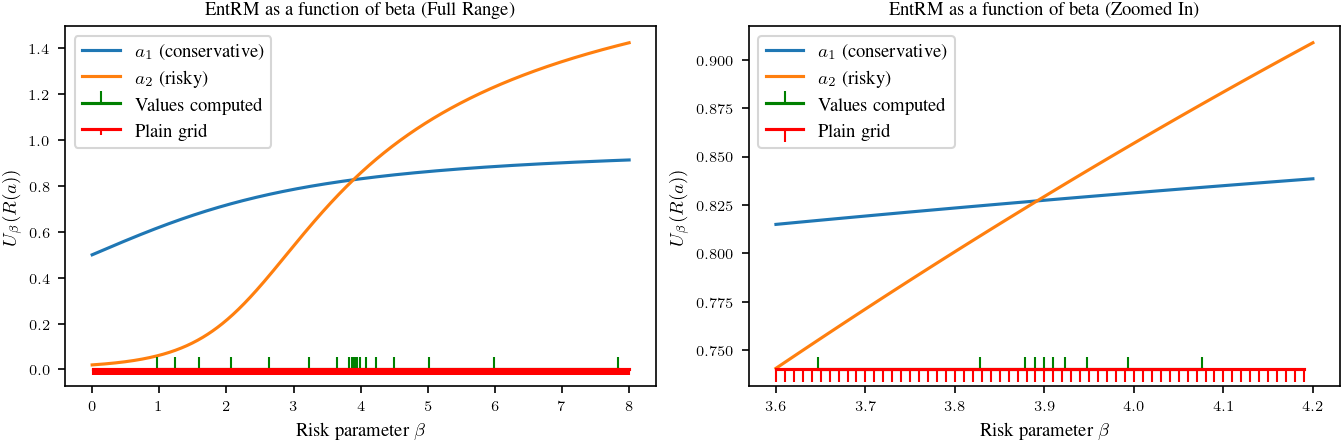

In [96]:
# Assuming u, d1, d2, intervals, accuracy, beta_max, b_min, b_max are already defined

distributions = [d1, d2]
abs_full = np.linspace(0, beta_max, 1000)
b_min, b_max = 3.6, 4.2
abs_zoomed = np.linspace(b_min, b_max, 100)

labels = [r"$a_1$ (conservative)", r"$a_2$ (risky)"]

# Create two subplots: one for the full plot, one for the zoomed-in plot
fig, axs = plt.subplots(1, 2, figsize=(9, 3))  # 2 rows, 1 column

# First subplot (full range)
for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs_full]
    axs[0].plot(abs_full, u_values, label=labels[i])
axs[0].plot(intervals, [0] * len(intervals), marker=2, color='g', label='Values computed')
min_accuracy = [accuracy + i*accuracy for i in range(int((beta_max)/accuracy))]
axs[0].plot(min_accuracy, [0] * len(min_accuracy), marker=3, color='r', label='Plain grid', markersize=3)
axs[0].legend(loc='upper left',  prop={'size': 9})
axs[0].set_title('EntRM as a function of beta (Full Range)')
axs[0].set_xlabel(r'Risk parameter $\beta$')
axs[0].set_ylabel(r'$U_\beta(R(a))$')

# Second subplot (zoomed-in range)
z_intervals = [x for x in intervals if b_min <= x <= b_max]
min_accuracy = [b_min + i * accuracy for i in range(int((b_max - b_min) / accuracy))]

for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs_zoomed]
    axs[1].plot(abs_zoomed, u_values, label=labels[i])
axs[1].plot(z_intervals, [0.74] * len(z_intervals), marker=2, color='g', label='Values computed')
axs[1].plot(min_accuracy, [0.74] * len(min_accuracy), marker=3, color='r', label='Plain grid')
axs[1].legend(loc='upper left', prop={'size': 9})
axs[1].set_title('EntRM as a function of beta (Zoomed In)')
axs[1].set_xlabel(r'Risk parameter $\beta$')
axs[1].set_ylabel(r'$U_\beta(R(a))$')

# fig.supxlabel(r'Risk parameter $\beta$')
# fig.supylabel(r'$U_\beta(R(a))$')
# Adjust layout
#plt.tight_layout()

# Show the plot
fig.savefig('intervals_ex.pdf')
plt.show()



In [97]:
print(len(intervals))

21


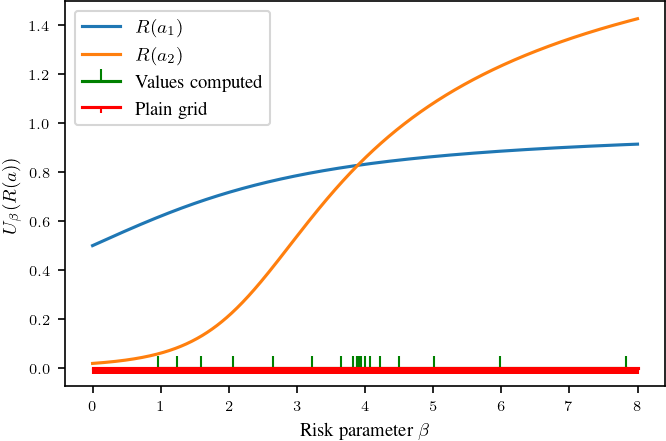

In [98]:
min_accuracy = [accuracy + i*accuracy for i in range(int((beta_max)/accuracy))]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))  # 2 rows, 1 column

# First subplot (full range)
for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs_full]
    ax.plot(abs_full, u_values, label=f'$R(a_{i+1})$')
ax.plot(intervals, [0] * len(intervals), marker=2, color='g', label='Values computed')
min_accuracy = [accuracy + i*accuracy for i in range(int((beta_max)/accuracy))]
ax.plot(min_accuracy, [0] * len(min_accuracy), marker=3, color='r', label='Plain grid', markersize=3)
ax.legend(loc='upper left',  prop={'size': 9})
#ax.set_title('EntRM in function of beta (Full Range)')
ax.set_xlabel(r'Risk parameter $\beta$')
ax.set_ylabel(r'$U_\beta(R(a))$')

fig.savefig('intervals_ex_full.pdf')


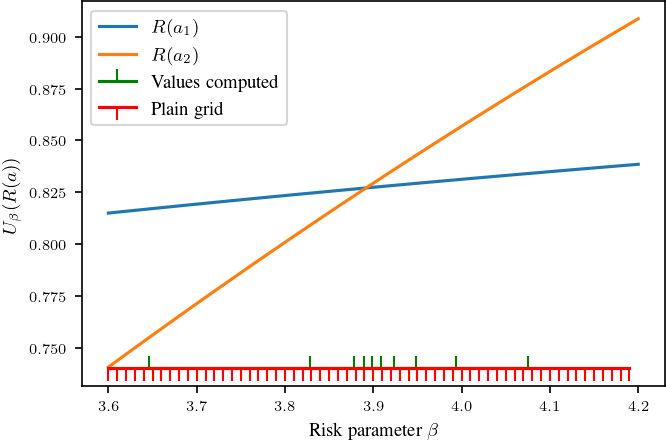

In [99]:
min_accuracy = [b_min + i * accuracy for i in range(int((b_max - b_min) / accuracy))]

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))  # 2 rows, 1 column

for i in range(len(distributions)):
    u_values = [u(distributions[i], beta) for beta in abs_zoomed]
    ax.plot(abs_zoomed, u_values, label=f'$R(a_{i+1})$')
ax.plot(z_intervals, [0.74] * len(z_intervals), marker=2, color='g', label='Values computed')
ax.plot(min_accuracy, [0.74] * len(min_accuracy), marker=3, color='r', label='Plain grid')
ax.legend(loc='upper left', prop={'size': 9})
#ax.set_title('EntRM in function of beta (Zoomed In)')
ax.set_xlabel(r'Risk parameter $\beta$')
ax.set_ylabel(r'$U_\beta(R(a))$')

fig.savefig('intervals_ex_zoom.pdf')


## Essayer de générer des distributions avec support aléatoire aussi ?
